### Work 2 - Keras/Tensorfolow Softmax, MLP and CNN on Fashion MNIST

Using Keras use Softmax, MLP, CNN on FashionMNIST dataset.
- acc/loss plots
- improvements?
- 2 and 2 examples of good and bad predictions (accordingly)

In [1]:
# imports

from IPython.display import HTML, Math, Latex, Markdown, display
 
# ----- load data 
import numpy as np

# ----- plots
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from random import shuffle

# ----- machine learning
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
 
from tensorflow.keras.datasets import fashion_mnist

In [2]:
# utils

def history(data):
    """ plots history graphs """
    with plt.xkcd():
        # :) 
        
        fig = plt.figure(figsize=(14, 8))
        layout = (2, 2)

        top  = plt.subplot2grid(layout, (0, 0), colspan=2) 
        bot  = plt.subplot2grid(layout, (1, 0), colspan=2) 
                
        colors = list('bgcmk')
        
        labels = {
            'acc'      : 'Training Accuracy',
            'val_acc'  : 'Validation Accuracy',
            'loss'     : 'Training  Loss',
            'val_loss' : 'Validation Loss',
        }
        
        
        shuffle(colors)
        for k, l in enumerate(['acc', 'val_acc']):
            if l in data.history:
                top.plot(data.history[l], color=colors[k], label=labels[l]) 
        
        shuffle(colors)
        for k, l in enumerate(['loss', 'val_loss']):
            if l in data.history:
                bot.plot(data.history[l], color=colors[-k], label=labels[l]) 
        

         # common things
        for ax in [top, bot]:
            ax.legend(loc="best")
            ax.set_xlim(0, max(data.epoch))
            ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: int(x+1)))
            
        fig.tight_layout()
        
def imagegrid(data, col=12, row=5, imagesize=28, rand=True, colors=[ "gist_gray" ]):
    """ dataset images preview """
    
    if rand is False:
        np.random.seed(42)
    perm = np.random.choice(np.arange(data.shape[0]), col*row, replace=False)
      
    size = (row, col)
    fig = plt.figure(figsize=size) 
    fig.set_size_inches((col, row))
    
    # index to row and col converters     
    row_idx = lambda i: i//col  
    col_idx = lambda i: i - row_idx(i)*col 
    

    for i, idx in enumerate(perm):
        ax = plt.subplot2grid(size, ( row_idx(i), col_idx(i) ) )
        image = data[idx].reshape(imagesize, imagesize) 
        ax.imshow(image, cmap=colors[i%len(colors)], interpolation='bilinear')
        ax.axis('Off')
        ax.set_title("")
    fig.subplots_adjust(hspace=.1,wspace=0)
    
def plot_prediction(test_drive_images, actual, expected, imagesize=28, labels=[]):
    """ plot results of prediction and hilight actual classes """
    
    
    # mapping dictionary
    values = {}
    max_vals = 0
    for i, cls in enumerate(actual):
        r = values.get(cls, {})
        r.update({i: cls == expected[i]})
        values.update({cls: r})
        
        if len(r) > max_vals:
            max_vals = len(r)
    
    text_width  = 2
    text_height = 6
    
    classes = 10
    
    rows = max_vals+1 if max_vals+1 > text_height else text_height
    cols = classes + text_width
    
    layout = (rows, cols)
    fig = plt.figure(figsize=(layout[1], layout[0]))
    

    
    ax = plt.subplot2grid(layout, (0, 10), colspan=text_width, rowspan=text_height )
    ax.axis('Off')
    text = "\n".join([f"{i} {s}" for i,s in enumerate(labels)])
    ax.text(1, 1, text,   ha='left', va='top', size=20 )
    
    for i in range(classes):
        ax = plt.subplot2grid(layout, (0, i) )
        ax.axis('Off')
        ax.text(0.1,0.1, i, ha='center', va='center', size=20 )
    
    rows_counter = {}
    for cls, items in values.items():
        for idx, valid in items.items(): 
            row_image = rows_counter.get(cls, 1)
            rows_counter.update({cls: row_image+1})
            ax = plt.subplot2grid(layout, (row_image, cls) )
        
            image = test_drive_images[idx].reshape(imagesize, imagesize) 
            ax.imshow(image, cmap="gray" if valid else "inferno", interpolation='bilinear')
            if not valid:
                ax.text(.2, .2, expected[idx], ha='left', va='top', size=13, color="w" )
                
            ax.axis('Off') 

def testset(data, labels, n):
    """return n random images and corresponsing labes """
    perm = np.random.choice(np.arange(data.shape[0]), n, replace=False)
    return data[perm], labels[perm]


def inspect(nn, image, frames=[1, 13, 35, 36, 41, 45, 61,  63]):
    
    layer_names   = [layer.name for layer in nn.layers]
    layer_outputs = [layer.output for layer in nn.layers]
    
    additional_pictures = [name for name in layer_names if name.startswith('conv2d') or name.startswith('max_pooling') ]
    
    model = keras.models.Model(inputs=nn.input, outputs = layer_outputs)
    

    size=(len(additional_pictures)+1, 1+len(frames))
    
    fig = plt.figure(figsize=size)
    fig.set_size_inches(size[1]*1.5, size[0]*1.5)
    
    pics_idx = {idx: name for idx, name in enumerate(layer_names) if name in additional_pictures}
    

    
    ax = plt.subplot2grid(size, (0, 0))  
    ax.imshow(image.reshape(28, 28), interpolation='bilinear')
    ax.axis('Off')
    
    frame_n = 0
    for idx in sorted(list(pics_idx.keys())):
        ax = plt.subplot2grid(size, (1+frame_n, 0)) 
        ax.text(0.5,0.5, layer_names[idx], ha='center', va='center', size=8)  
        ax.axis('Off') 
        frame_n += 1
    

    frame = model.predict(image.reshape(1, 28, 28, 1))
    
    for k, n in enumerate(frames):
        ax = plt.subplot2grid(size, (0, 1+k)) 
        ax.text(0.5,0.5, n, ha='center', va='center', size=10)  
        ax.axis('Off') 
        
        frame_n = 1
        for idx in sorted(list(pics_idx.keys())):
            ax = plt.subplot2grid(size, (frame_n, 1+k)) 
            ax.imshow(frame[idx][0, : , :, n])
            frame_n += 1

### Step 1 - Loading & Classes Declaration

In [3]:
(data_images, data_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [4]:
# classes - used for visual representation at the end of work
clss = []
clss.append('T-shirt/top')
clss.append('Trouser')
clss.append('Pullover')
clss.append('Dress')
clss.append('Coat')
clss.append('Sandal')
clss.append('Shirt')
clss.append('Sneaker')
clss.append('Bag')
clss.append('Ankle boot')

### Visualization

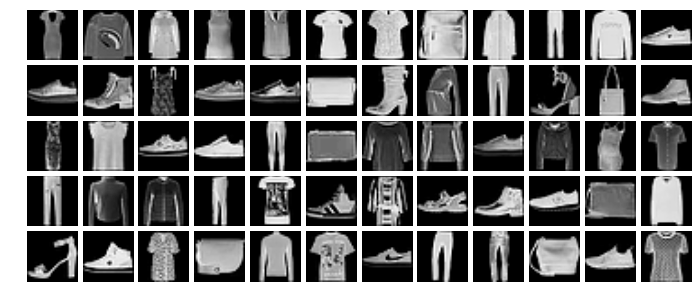

In [5]:
imagegrid(data=data_images, imagesize=28)

In [6]:
# what shapes we have
data_images.shape,  data_labels.shape, test_images.shape,  test_labels.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

### Improvements

 - I have increas batch size to 64, we can lower it but its not effective (sometimes)
 - More epoch is better (but not so much so we wouldn't run into overfitting)
 - Speedup - we training only on part of training set.
 - AdamOptimizer: learning rate 0.01

In [7]:
display(Markdown("## Lovering dataset resolutions"))

data_images = data_images / 256
test_images = test_images / 256

train_set_size = int(data_images.shape[0]/10)

#-------------
"train set size", train_set_size

## Lovering dataset resolutions

('train set size', 6000)

## a) Step 2 - "Softmax Regression" Model Creation and Training

## Accurasy change per epoch (acc/loss)

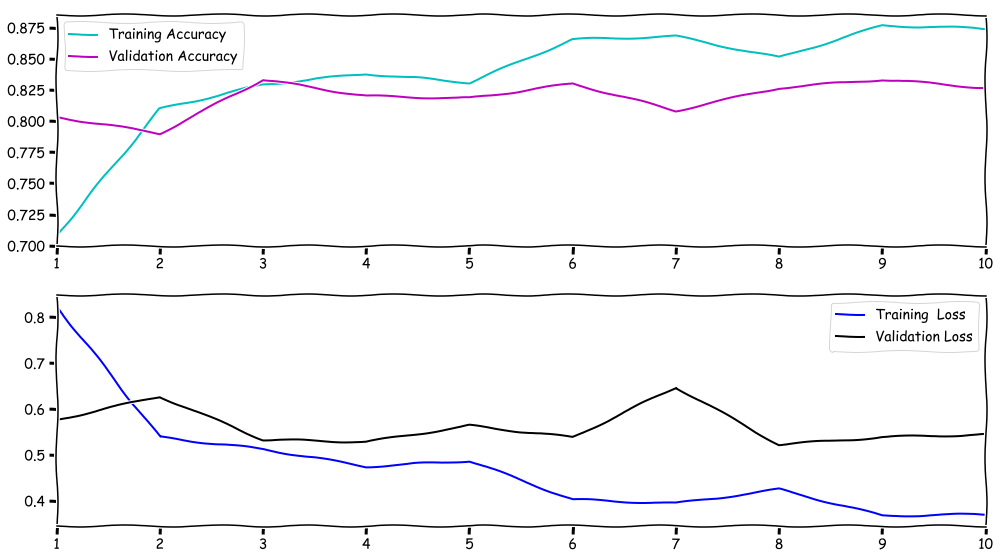

In [9]:
softmax_regresion = tf.keras.models.Sequential()
softmax_regresion.add(tf.keras.layers.Flatten())
softmax_regresion.add(tf.keras.layers.Dense(10))
softmax_regresion.add(tf.keras.layers.Activation('softmax'))

# compiling 
softmax_regresion.compile(
    optimizer = tf.train.AdamOptimizer(learning_rate=0.01), 
    loss      = 'sparse_categorical_crossentropy',
    metrics   = [ 'accuracy' ]
)
 
# fitting model
display(Markdown("## Accurasy change per epoch (acc/loss)"))
hist=softmax_regresion.fit(
        data_images[:train_set_size],  
        data_labels[:train_set_size], 
        validation_split=0.1,
        batch_size=64, 
        epochs=10, 
        verbose=0
)
history(hist)


## a) Step 2 - Validation

In [10]:
display(Markdown("#### Testing \"test\" set (acc)"))

softmax_regresion.evaluate(test_images, test_labels, verbose=0)

#### Testing "test" set (acc)

[0.5871815299987793, 0.8164]

In [12]:
display(Markdown("#### Testing rest of training set (acc)"))

softmax_regresion.evaluate(data_images[train_set_size:], data_labels[train_set_size:], verbose=0)

#### Testing rest of training set (acc)

[0.5608263392448425, 0.824037]

#### Random 100 images prediction

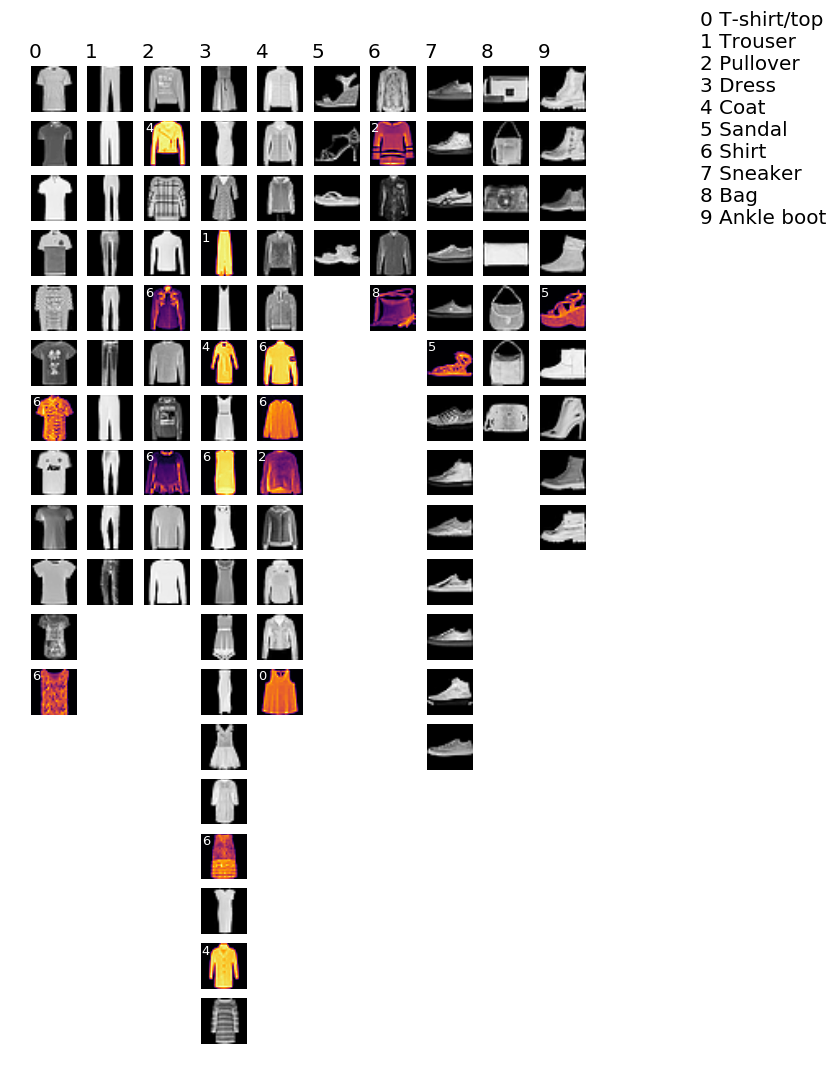

In [14]:
display(Markdown("#### Random 100 images prediction"))

test_drive_images, test_drive_labels = testset(test_images, test_labels, 100)
predicts = softmax_regresion.predict(test_drive_images)
predicts.argmax(axis=-1), test_drive_labels


plot_prediction(test_drive_images, predicts.argmax(axis=-1), test_drive_labels, labels=clss, imagesize=28)

### b) Step 2 - "Perseptron" Model Creation and Training

## Accurasy change per epoch (acc/loss)

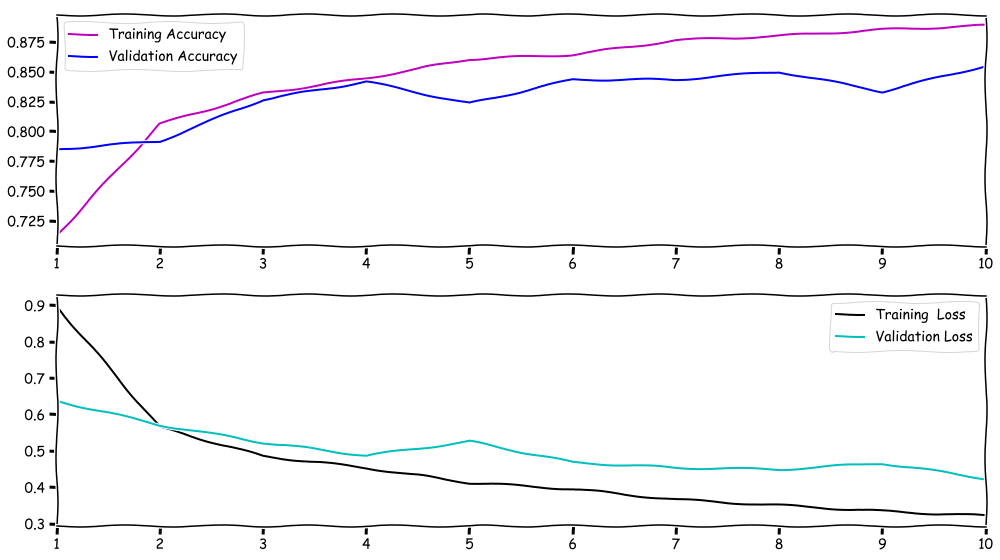

In [15]:
perceptron = tf.keras.models.Sequential()
perceptron.add(tf.keras.layers.Flatten())
perceptron.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
perceptron.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))

# compiling 
perceptron.compile(
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001), 
    loss      = 'sparse_categorical_crossentropy',
    metrics   = [ 'accuracy' ]
)


# fitting model
display(Markdown("## Accurasy change per epoch (acc/loss)"))
history(
    perceptron.fit(
        data_images[:train_set_size],  
        data_labels[:train_set_size], 
        validation_split=0.1,
        batch_size=64, 
        epochs=10, 
        verbose=0
    )
)

### b) Step 2 - Validation

In [16]:
display(Markdown("### Testing \"test\" set (acc)"))

perceptron.evaluate(test_images, test_labels, verbose=0)

### Testing "test" set (acc)

[0.4624367660999298, 0.8399]

In [17]:
display(Markdown("### Testing rest of training set (acc)"))

perceptron.evaluate(data_images[train_set_size:], data_labels[train_set_size:], verbose=0)

### Testing rest of training set (acc)

[0.43720433645778234, 0.85161114]

### Random 100 images prediction

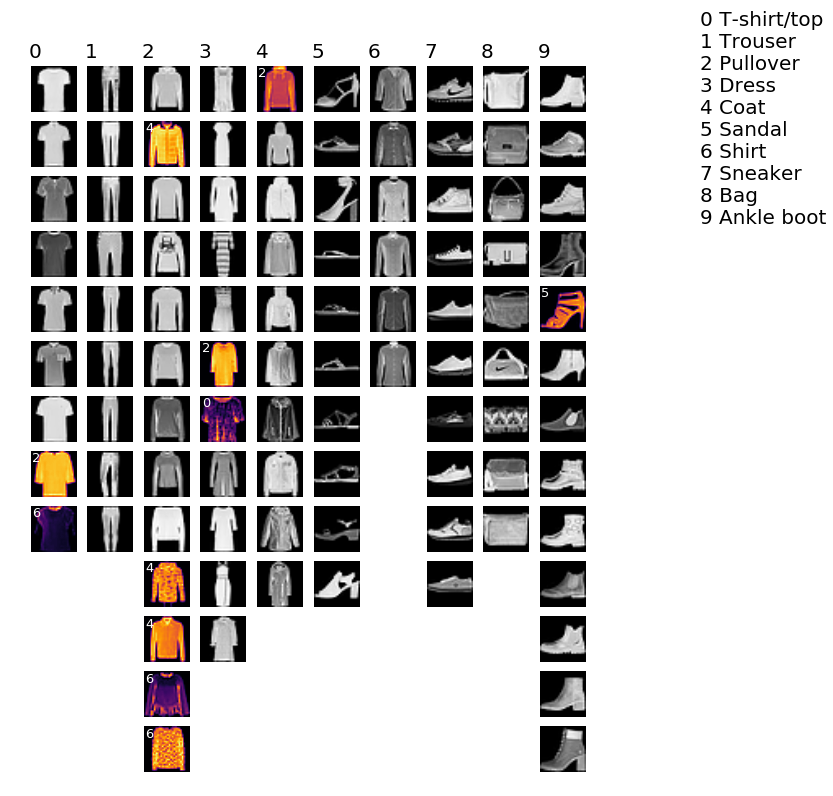

In [18]:
display(Markdown("### Random 100 images prediction"))

test_drive_images, test_drive_labels = testset(test_images, test_labels, 100)
predicts = perceptron.predict(test_drive_images)
predicts.argmax(axis=-1), test_drive_labels


plot_prediction(test_drive_images, predicts.argmax(axis=-1), test_drive_labels, imagesize=28, labels=clss)

### c) Step 2 - "Basic CNN" Model Creation and Training

In [19]:
# google colab optimizations - part 1

import os

if os.environ.get('COLAB_GPU', 0) == 1:
    K.set_image_data_format('channels_first')

In [20]:
# google colab optimizations - part 2
# channel first gpu optimziation

re_shape = (28, 28, 1) if  K.image_data_format() == "channels_last" else (1, 28, 28)

data_images_cnn=data_images.reshape(60000, *re_shape)
test_images_cnn=test_images.reshape(10000, *re_shape)

## Accurasy change per epoch (acc/loss)

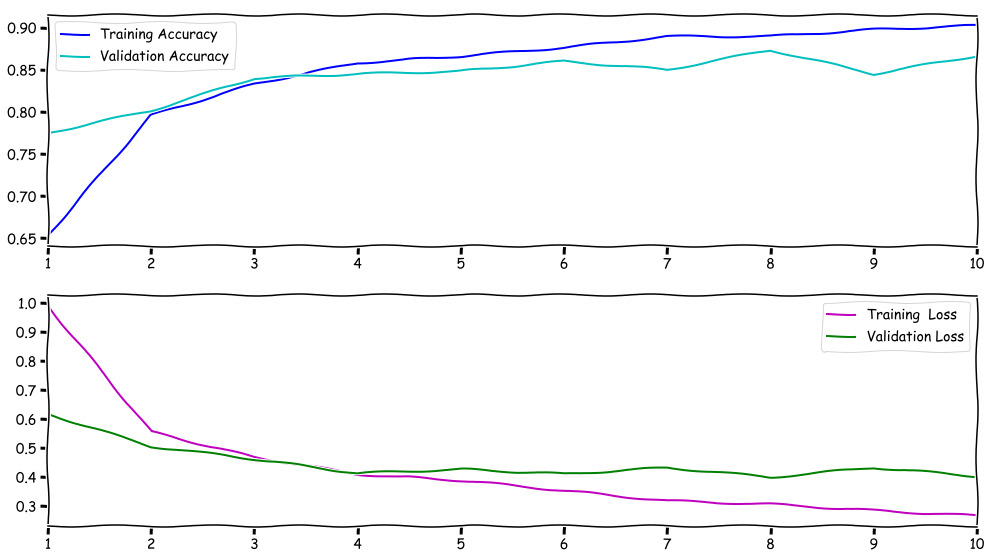

In [21]:
# actual model creating and training

cnn = tf.keras.models.Sequential()
cnn.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=re_shape))
cnn.add(tf.keras.layers.MaxPooling2D(2, 2))
cnn.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
cnn.add(tf.keras.layers.MaxPooling2D(2,2))
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(128, activation='relu'))
cnn.add(tf.keras.layers.Dense(10, activation='softmax'))

cnn.compile(
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001), 
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

display(Markdown("## Accurasy change per epoch (acc/loss)"))
history(
    cnn.fit(
        data_images_cnn[:train_set_size],  
        data_labels[:train_set_size], 
        validation_split=0.1,
        batch_size=64, 
        epochs=10, 
        verbose=0
    )
)

### c) Step 2 - Validating

In [22]:
display(Markdown("### Testing \"test\" set (acc)"))

cnn.evaluate(test_images_cnn, test_labels, verbose=0)

### Testing "test" set (acc)

[0.42739112832546233, 0.8513]

In [23]:
display(Markdown("### Testing rest of training set (acc)"))

perceptron.evaluate(data_images_cnn[train_set_size:], data_labels[train_set_size:], verbose=0)

### Testing rest of training set (acc)

[0.43720433645778234, 0.85161114]

### Random 100 images prediction

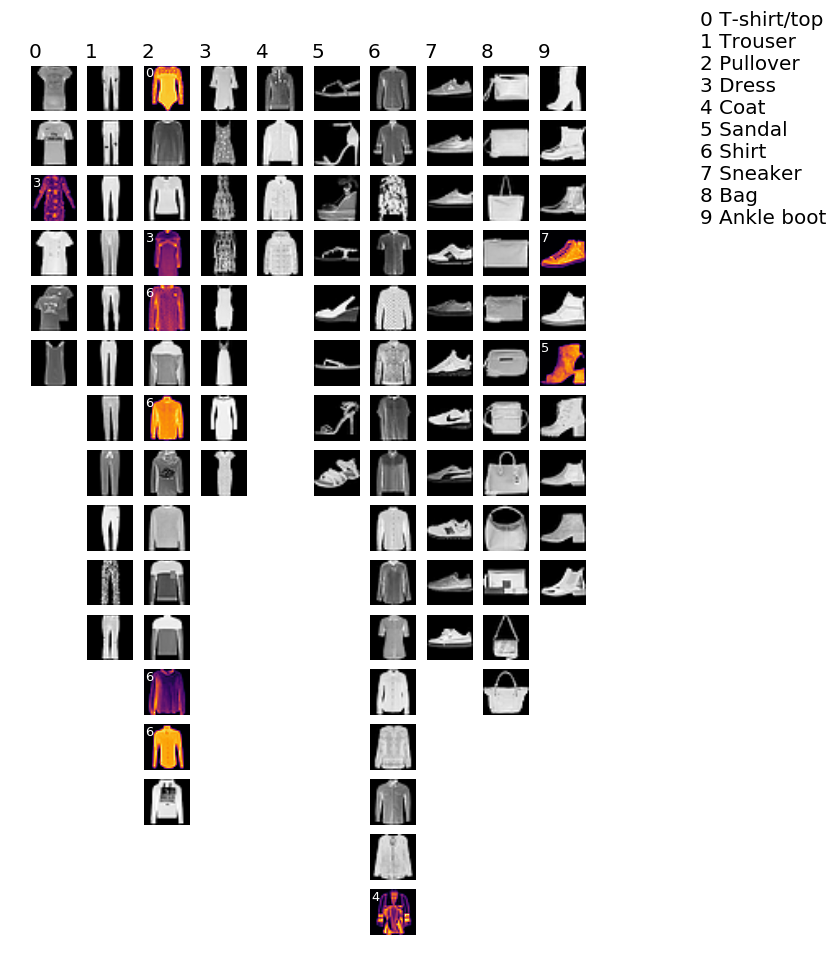

In [24]:
display(Markdown("### Random 100 images prediction"))

test_drive_images, test_drive_labels = testset(test_images_cnn, test_labels, 100)
predicts = cnn.predict(test_drive_images)
predicts.argmax(axis=-1), test_drive_labels


plot_prediction(test_drive_images, predicts.argmax(axis=-1), test_drive_labels, imagesize=28, labels=clss)

### c) Step 2 - Predictions Inspection

In [25]:
results_ok    = [idx for idx, cls in enumerate(predicts.argmax(axis=-1)) if cls == test_drive_labels[idx]]
results_wrong = [idx for idx, cls in enumerate(predicts.argmax(axis=-1)) if cls != test_drive_labels[idx]]

### OK Example № 1

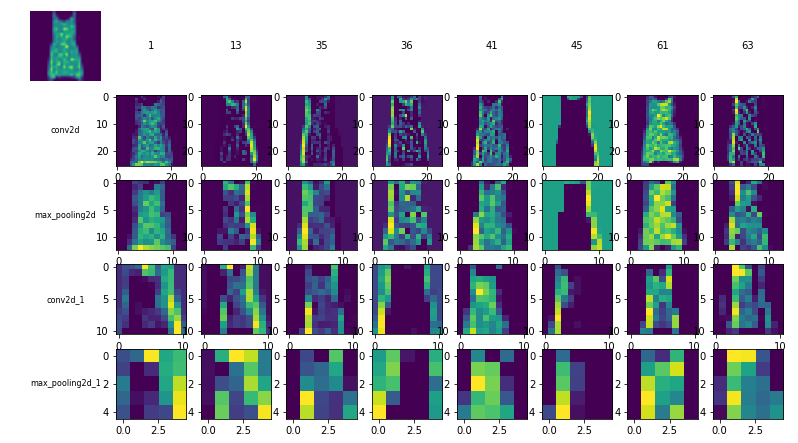

In [26]:
display(Markdown("### OK Example № 1"))
inspect(cnn, test_drive_images[np.random.choice(results_ok)])

### OK Example № 2

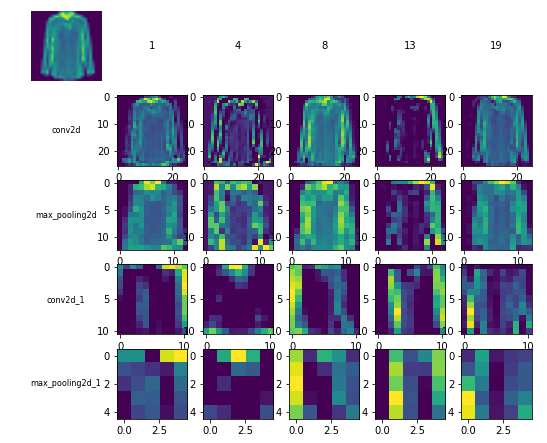

In [27]:
display(Markdown("### OK Example № 2"))
inspect(cnn, test_drive_images[np.random.choice(results_ok)], frames=[1, 4, 8, 13, 19])

### Bad prediction example

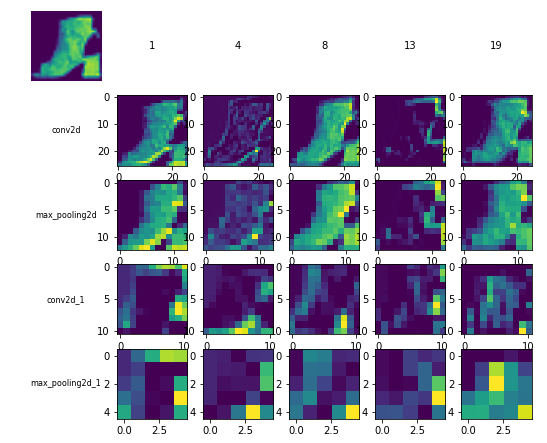

In [28]:
display(Markdown("### Bad prediction example"))

inspect(cnn, test_drive_images[np.random.choice(results_wrong)], frames=[1, 4, 8, 13, 19])